# Jupyter notebook: sgRNA sequence motifs correlating with repression strength

## Overview

This Jupyter notebook is an attempt to identify sequence motifs or variants in sgRNAs that improve or decrease the efficiency of CRISPRi reression.

## Background

Two CRISPRi libraries are available for Synechocystis, version 1.0 with only 2 sgRNAs and version 2.0 with on average 5 sgRNAs per gene.
Each sgRNA targets the 5'-region of a gene, meaning the transcription start site (TSS) or the region downstream of it.
The sgRNA mediates the binding efficiency of the dCas9 enzyme. However, previous and current sequencing results show that the repression strength is by no means uniform.
In fact, variation between the efficiency of sgRNAs mediating repression is enormous. Repression efficiency is partly influenced by the distance to the TSS, and partly
by unknown sequence features. Such features could be:

- folding, secondary structures, such as hairpins
- off target binding (competitive binding)
- GC content
- so far unknown motifs

For details regarding the ongoing efforts to determine all gene's fitness contribution, see the [CRISPRi library github repository](https://github.com/m-jahn/R-notebook-crispri-lib) that contains this notebook and further information. The R analysis pipeline that led to the selection of the ncRNAs of interest can be viewed on [m-jahn.github.io](https://m-jahn.github.io/R-notebook-crispri-lib/CRISPRi_V2_data_processing.nb.html).

Tasks:

- import sgRNA sequences
- import sgRNA fitness data and merge with sequences
- group sgRNAs in different binding classes (or continuous target variable?)
- determine sequence motifs that lead to high repression efficiency and/or correlation
- determine sequence motifs that lead to low repression

Strategy:

- nucleotide sequence is available, needs to be trimmed and aligned
- can be one-hot-encoded by position and nucleotide (pos1_A: T/F, pos1_T: T/F, ...)
- test and apply different ML models:
  - tree-based models including feature importance: Random Forest (RF), gradient boosting (GB)
  - NN-based models without feature importance: MLP, CNN


## Import of required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import Bio.SeqIO
from requests import get
from io import StringIO

## Data import and re-arrangement

The first task is to import the sequence data from a fasta file into a data frame.
The data is stored as reference "genome" for read mapping, in the [CRISPRi NGS pipeline](https://github.com/m-jahn/CRISPRi-lib-pipe/) on github.

In [33]:
dir_fasta_db = "https://github.com/m-jahn/CRISPRi-lib-pipe/raw/main/ref/Synechocystis_v2.fasta"
con_fasta_db = get(dir_fasta_db, allow_redirects = True)
fasta_db = Bio.SeqIO.parse(StringIO(con_fasta_db.text), "fasta")

In [34]:
# iterate through fasta DB connection and save results to list
fivep_adapter = "CAGTGATAGAGATACTGGGAGCTA"
threep_adapter = "GTTTTAGAGCTAGAAATAGCAAGTTAAAAT"

fasta_id = []
fasta_seq = []
for fasta_record in fasta_db:
    fasta_id.append(fasta_record.id)
    threep_pos = fasta_record.seq.find(threep_adapter)
    fasta_seq.append(fasta_record.seq[len(fivep_adapter) : threep_pos])

In [39]:
# make new pd data frame from lists
fasta_df = pd.DataFrame()

In [40]:
fasta_df["sgRNA_target"] = fasta_id
fasta_df["seq"] = fasta_seq
fasta_df["seq_len"] = [len(str(i)) for i in fasta_seq]

The second task is to import the main data table with fitness, correlation and repression efficiency for every sgRNA.

In [82]:
data = pd.read_csv("../data/output/fitness_sgRNA.csv")
data.iloc[:, 0:14].head(n = 5)

,sgRNA,sgRNA_target,sgRNA_position,condition,carbon,light,treatment,date,time,log2FoldChange,lfcSE,stat,pvalue,padj
0,aat|22,aat,22,"HC, HL",HC,HL,NaN,2021_02_07,0,0.000000,0.000000,NaN,1.000000,1.000000
1,aat|22,aat,22,"HC, HL",HC,HL,NaN,2021_02_09,4,0.011120,0.118747,0.115747,0.907853,0.972060
2,aat|22,aat,22,"HC, HL",HC,HL,NaN,2021_02_11,8,0.054991,0.122096,0.533672,0.593569,0.721617
3,aat|22,aat,22,"HC, HL",HC,HL,NaN,2021_02_12,10,0.091747,0.126932,1.013406,0.310866,0.443794
4,aat|22,aat,22,"HC, IL",HC,IL,NaN,2021_09_28,0,0.000000,0.000000,NaN,1.000000,1.000000


The data frame needs to be reduced/summarized to the desired shape. We don't need fitness and log2FC for all conditions and time points.
All we need instead is 1 sgRNA per row, with:

- mean absolute fitness effect over all conditions
- repression efficiency (relative score between 0 and 1)
- correlation (also relative score between 0 and 1)

In [133]:
data_reduced = data[["sgRNA", "sgRNA_target", "sgRNA_position", "sgRNA_correlation", "sgRNA_efficiency", "fitness"]]

In [ ]:
data_reduced = data_reduced.groupby(["sgRNA_target", "sgRNA"]).mean()

## Preparation for ML training and tuning

1. Remove non-responsive genes (no sgRNA has an effect on fitness)
2. Choose and optionally scale/bin target variable
3. One-hot encode sgRNA sequences
4. Split data into training and test data set

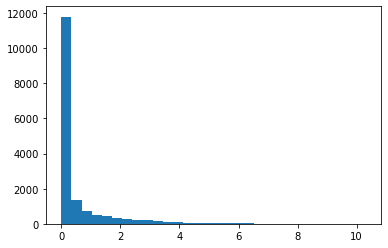

In [131]:
plt.hist(abs(data_reduced["fitness"]), bins = 30);

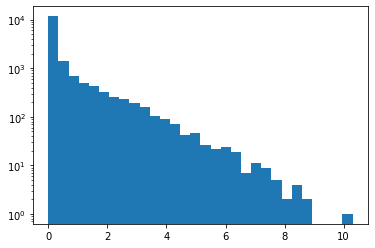

In [130]:
plt.hist(abs(data_reduced["fitness"]), bins = 30, log=True);

In [ ]:
abs(data_reduced["fitness"]) >= 1

In [135]:
data_reduced

,sgRNA_position,sgRNA_correlation,sgRNA_efficiency,fitness
sgRNA,,,,
AT103|115,115.0,0.595502,0.469862,0.135691
AT103|18,18.0,0.514383,0.360110,0.023831
AT103|34,34.0,0.443806,1.000000,-0.098526
AT103|57,57.0,0.651909,0.255254,0.103907
AT103|7,7.0,0.591169,0.562867,0.201842
...,...,...,...,...
zwf|100,100.0,0.889456,0.560450,0.097857
zwf|117,117.0,0.913516,1.000000,-0.495144
zwf|128,128.0,0.931130,0.704501,0.025069
